In [1]:
import torch
from diffusers import AutoencoderKL, DiffusionPipeline
from torchvision.io import read_video
import torchvision.transforms as T
import torchvision.transforms.v2 as T2
from svd_cross_att import get_attn_from_pipe
import torch
import matplotlib.pyplot as plt

/home/marco/miniconda3/envs/tadp/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/marco/miniconda3/envs/tadp/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

In [2]:
def preprocess_video(path):
    video = read_video(path, output_format='TCHW')[0]
    video = video.float().half()
    video = video.to('cuda')
    # video = T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])(video)
    video = T2.UniformTemporalSubsample(8)(video)
    # video = T.Resize((256, 256))(video)
    return video


In [37]:
def get_latents(pipe, video):
    # video in format frames, c, w, h
    latent_dist = pipe.vae.encode(video).latent_dist
    latents = latent_dist.sample()
    latents = latents.permute((1, 0, 2, 3))
    latents = latents.reshape(1, *latents.shape)
    latents = pipe.vae.config.scaling_factor * latents
    # latents in format frames, c, w, ph
    print(latents.shape)
    return latents

def decode_latents(pipe, latents):
    # latents = 1 / pipe.vae.config.scaling_factor * latents

    batch_size, channels, num_frames, height, width = latents.shape
    latents = latents.permute(0, 2, 1, 3, 4).reshape(batch_size * num_frames, channels, height, width)

    image = pipe.vae.decode(latents).sample
    video = image[None, :].reshape((batch_size, num_frames, -1) + image.shape[2:]).permute(0, 2, 1, 3, 4)
    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
    video = video.float()[0].permute(1, 2, 3, 0)
    return video

In [4]:
def get_first_layer_attn(pipe, latents):
    attns = get_attn_from_pipe(
        pipe=pipe,
        prompt='kitchen',
        latents=latents
    )
    return attns


In [5]:
pipe = DiffusionPipeline.from_pretrained("ali-vilab/text-to-video-ms-1.7b", torch_dtype=torch.float16, variant="fp16")
pipe = pipe.to('cuda')

/home/marco/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
video = preprocess_video('./bike.avi')
print(video.shape)

torch.Size([8, 3, 240, 320])


/home/marco/miniconda3/envs/tadp/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


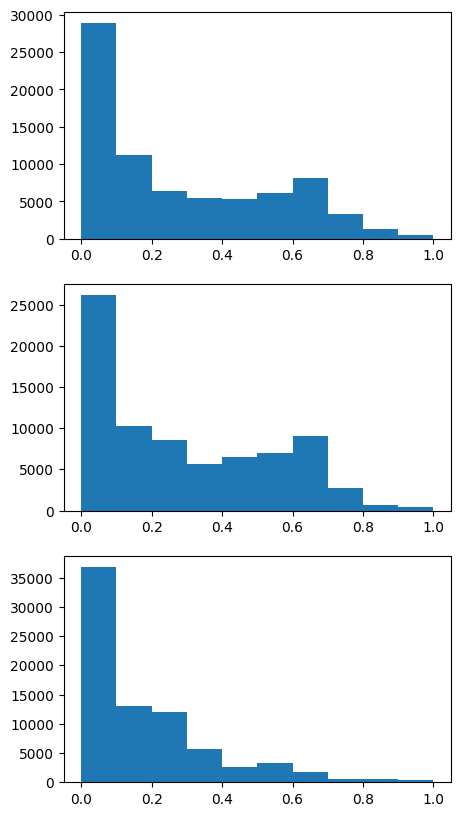

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
for i in range(3):
    axes[i].hist(video[0][i].cpu().flatten()/255)
plt.show()

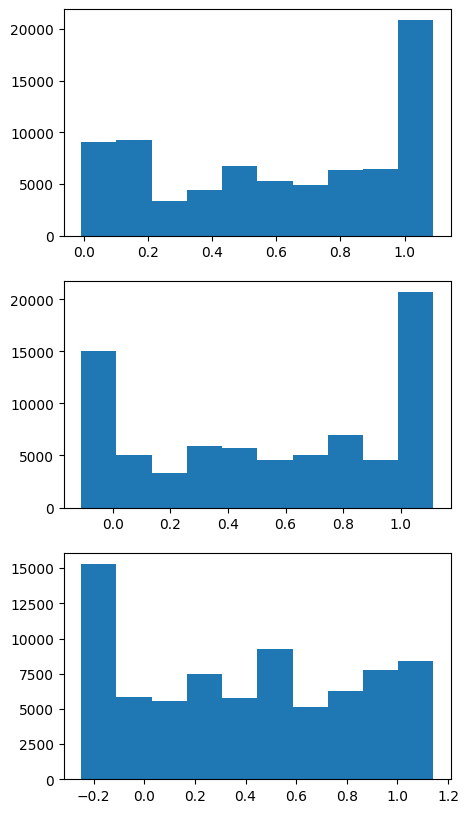

In [8]:
latents = get_latents(pipe, video)
decoded_video = decode_latents(pipe, latents).detach().permute(0, 3, 1, 2)
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
for i in range(3):
    axes[i].hist(decoded_video[0][i].cpu().flatten())
plt.show()

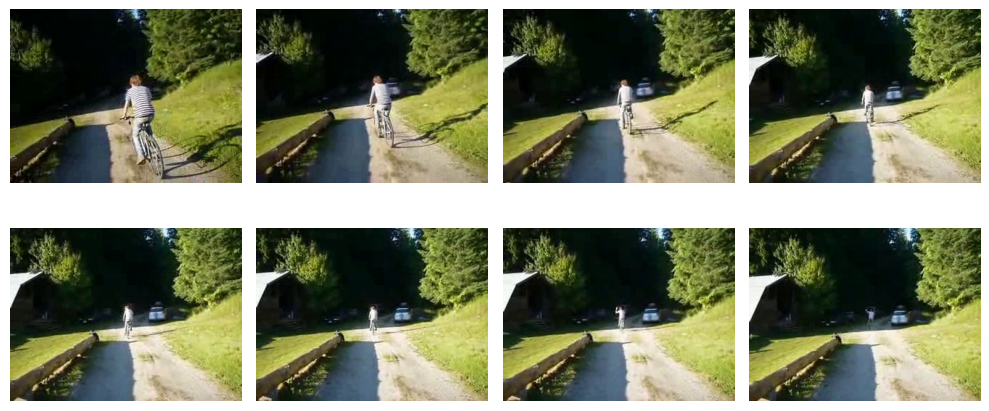

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Plot each image
for i, ax in enumerate(axes.flatten()):
    ax.imshow(video[i].to(int).detach().cpu().permute(1, 2, 0))
    ax.axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


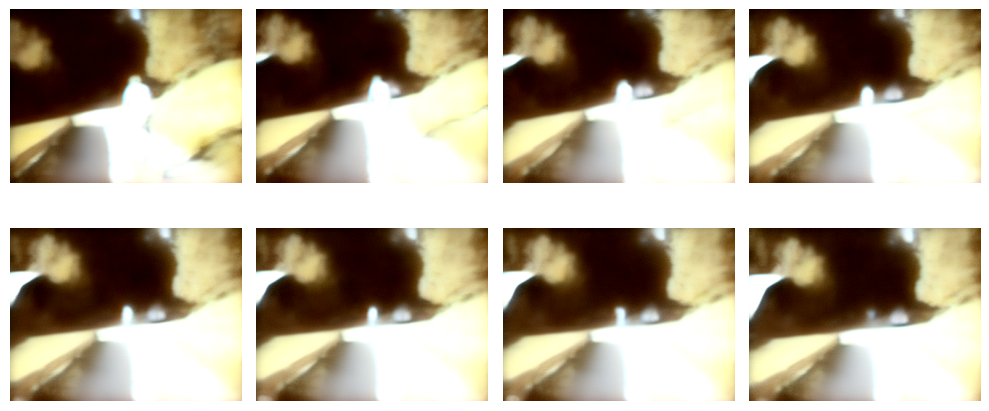

In [38]:
latents = get_latents(pipe, video)
decoded_video = decode_latents(pipe, latents).detach().cpu()

# Create a figure to display the images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Plot each image
for i, ax in enumerate(axes.flatten()):
    # ax.imshow(images[i], cmap='gray')
    ax.imshow(decoded_video[i])
    ax.axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()

torch.Size([8, 4, 30, 40])


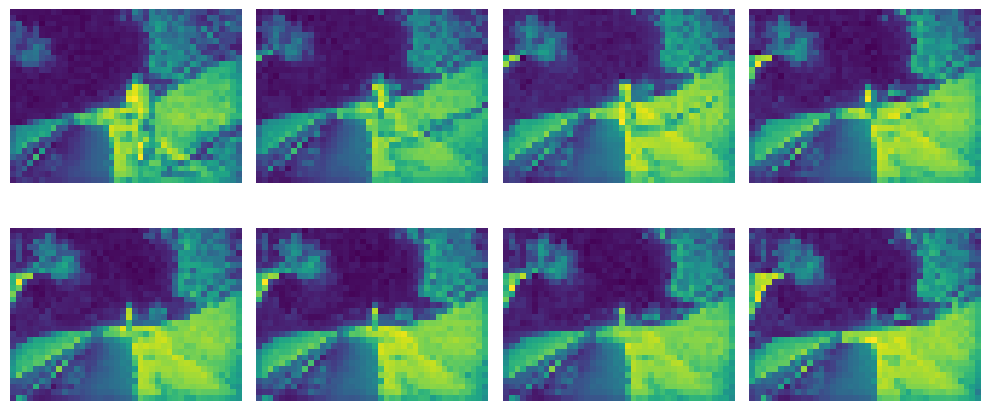

In [11]:
latents = get_latents(pipe, video)
latents = latents.reshape(4, 8, 30, 40)
latents = latents.permute(1, 0, 2, 3)
latents = latents.detach().cpu()
print(latents.shape)

# Create a figure to display the images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Plot each image
for i, ax in enumerate(axes.flatten()):
    # ax.imshow(images[i], cmap='gray')
    ax.imshow(latents[i][0])
    ax.axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()


torch.Size([8, 320, 15, 20])


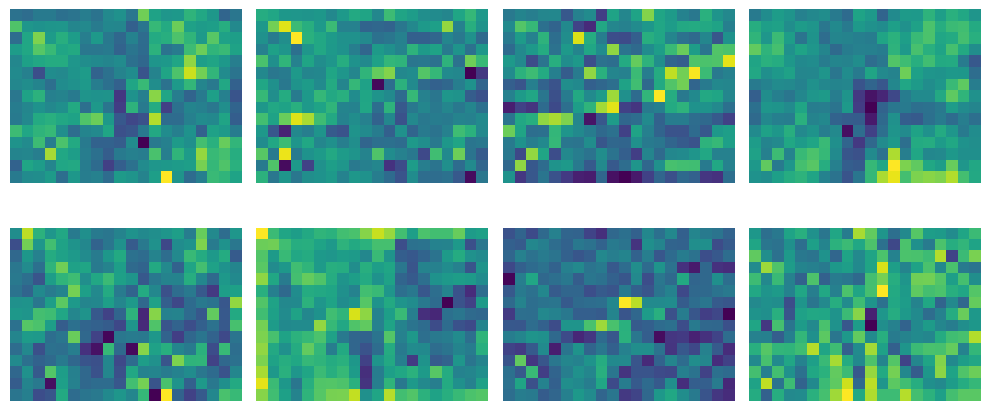

In [12]:
latents = get_latents(pipe, video)
attns = get_first_layer_attn(pipe, latents)
print(attns.shape)
images = [image.detach().cpu().numpy() for image in attns[0][:8]]

# Create a figure to display the images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Plot each image
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()